## *Import neccessary libraries*
1.  pandas/numpy → data handling
1.  seaborn/matplotlib → plotting
1.  TSNE → dimensionality reduction for visualization
1.  StandardScaler → feature scaling before clustering/TSNE
1.  KMeans → company segmentation
1.  SimpleImputer → missing value handling
1.  make_pipeline → clean preprocessing+model flow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [7]:
# 1. Load the Forbes 2000 dataset from local CSV file
#    - sep=';' because the file uses semicolons instead of commas as column separators
#    - thousands=',' so numbers like "1,234" are correctly parsed as 1234
#    - engine='python' ensures compatibility with the custom separator
df = pd.read_csv(
    r"D:\Sharanya\Forbes_Dashboard\data\Forbes_2000_Companies_2025.csv",
    sep=';',
    thousands=',',
    engine='python'
)

# 2. Specify the numeric columns we want to clean/convert
num_cols = ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)']

# 3. Define a helper function to safely convert messy strings into floats
def safe_float(x):
    """
    Convert a value into a clean float:
    - If value is NaN, return NaN
    - Remove commas and spaces
    - Ensure only one decimal point (remove extras if present)
    - Return float if conversion is possible, else NaN
    """
    if pd.isna(x):
        return np.nan
    s = str(x).replace(',', '').replace(' ', '')
    # Keep only the first decimal point; remove extra ones if data is messy
    if s.count('.') > 1:
        s = s.replace('.', '', s.count('.') - 1)
    try:
        return float(s)
    except ValueError:
        return np.nan

# 4. Apply the cleaning function to each of the numeric columns
for c in num_cols:
    df[c] = df[c].apply(safe_float)

# 5. (Optional) Remove any rows where one of the key numeric columns is missing
df = df.dropna(subset=num_cols)

# 6. Print the number of rows remaining after cleaning
print("Rows after cleaning:", len(df))


Rows after cleaning: 2000


In [8]:
# 7. Quick health check
print(df.info())
print(df[num_cols].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rank               2000 non-null   int64  
 1   Company            2000 non-null   object 
 2   Headquarters       2000 non-null   object 
 3   Industry           2000 non-null   object 
 4   Sales ($B)         2000 non-null   float64
 5   Profit ($B)        2000 non-null   float64
 6   Assets ($B)        2000 non-null   float64
 7   Market Value ($B)  2000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 125.1+ KB
None
        Sales ($B)  Profit ($B)  Assets ($B)  Market Value ($B)
count  2000.000000  2000.000000  2000.000000        2000.000000
mean     26.441630     3.043314   121.087279          45.641756
std      47.928105    20.576251   395.754878         154.511821
min     -21.470000   -21.650000     0.181000           0.175000
25%       6.147500     0.

In [ ]:
# 8. Key aggregates — Calculate total values across all companies

# Print section header
print("\n=== GLOBAL TOTALS ===")

# Total Sales across all companies (in Trillions)
# sum() → total sales in billions → divide by 1e3 to convert billions → trillions
# {:,.1f} → formats with commas and 1 decimal place
print("Total Sales   : ${:,.1f} T".format(df['Sales ($B)'].sum() / 1e3))

# Total Profit across all companies (in Trillions)
print("Total Profit  : ${:,.1f} T".format(df['Profit ($B)'].sum() / 1e3))

# Total Assets across all companies (in Trillions)
print("Total Assets  : ${:,.1f} T".format(df['Assets ($B)'].sum() / 1e3))

# Total Market Value (Market Capitalization) across all companies (in Trillions)
print("Total Mkt Cap : ${:,.1f} T".format(df['Market Value ($B)'].sum() / 1e3))



=== GLOBAL TOTALS ===
Total Sales   : $52.9 T
Total Profit  : $6.1 T
Total Assets  : $242.2 T
Total Mkt Cap : $91.3 T


In [10]:
# 9. Top 10 by Market Value
top10 = df.sort_values('Market Value ($B)', ascending=False).head(10)
print("\n=== TOP 10 MARKET CAP ===")
print(top10[['Rank', 'Company', 'Market Value ($B)']])


=== TOP 10 MARKET CAP ===
    Rank                                   Company  Market Value ($B)
10    11                                     Apple            3143.82
9      9                                 Microsoft            2913.01
46    47                                    NVIDIA            2708.64
4      5                                    Amazon            2005.64
8      9                                  Alphabet            1973.64
3      4  Saudi Arabian Oil Company (Saudi Aramco)            1663.38
20    20                            Meta Platforms            1381.87
1      2                        Berkshire Hathaway            1145.46
68    69                                     Tesla             916.55
67    68                                  Broadcom             904.23


C:\Users\NEW\AppData\Local\Temp\ipykernel_6624\2018627531.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


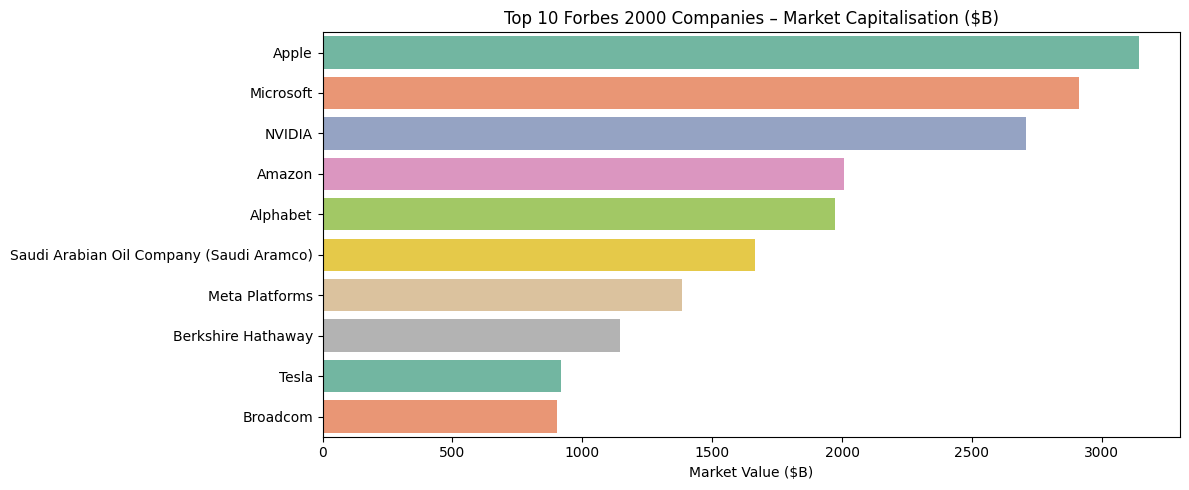

In [11]:
# 10. Top 10 by Market Value – bar chart
top10 = (df
         .sort_values('Market Value ($B)', ascending=False)
         .head(10))

plt.figure(figsize=(12, 5))
sns.barplot(
    data=top10,
    y='Company',
    x='Market Value ($B)',
    palette='Set2'
)
plt.title('Top 10 Forbes 2000 Companies – Market Capitalisation ($B)')
plt.xlabel('Market Value ($B)')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [12]:
# 11. Sector median profit margin
df['Profit Margin'] = df['Profit ($B)'] / df['Sales ($B)']
sector_pm = df.groupby('Industry')['Profit Margin'].median().sort_values(ascending=False).head(10)
print("\n=== TOP PROFIT MARGINS BY INDUSTRY ===")
print(sector_pm)


=== TOP PROFIT MARGINS BY INDUSTRY ===
Industry
Construction, Chemicals, Raw Materials    0.319767
Diversified Financials                    0.177975
Banking                                   0.169451
Engineering, Manufacturing                0.166487
IT Software & Services                    0.163744
Semiconductors                            0.159674
Business Services & Supplies              0.131413
Drugs & Biotechnology                     0.131119
Utilities                                 0.118249
Health Care Equipment & Services          0.108949
Name: Profit Margin, dtype: float64


C:\Users\NEW\AppData\Local\Temp\ipykernel_6624\3581044315.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


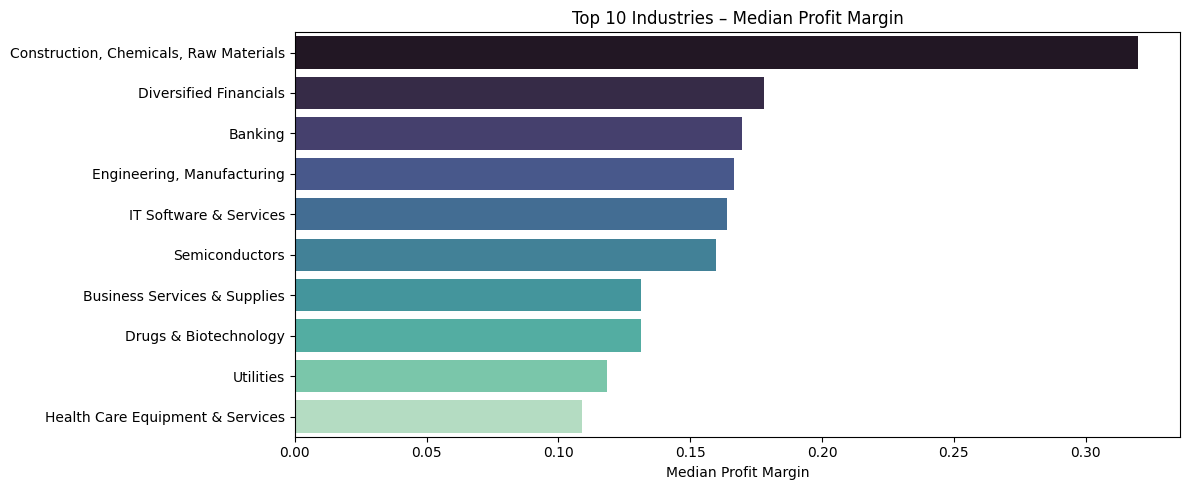

In [13]:
# 12. Calculate and plot the Top 10 Industries by Median Profit Margin

# Create a new column: Profit Margin = Profit / Sales
# Both are in $B, so the ratio is unitless (fraction, can be converted to %)
df['Profit Margin'] = df['Profit ($B)'] / df['Sales ($B)']

# Group by 'Industry', take median profit margin, sort high to low, pick top 10
sector_pm = (
    df.groupby('Industry')['Profit Margin']
      .median()                          # median handles outliers better than mean
      .sort_values(ascending=False)       # sort so highest margins are first
      .head(10)                            # select top 10 industries
)

# Create the plot
plt.figure(figsize=(12, 5))  # wide chart for better readability

# Horizontal bar chart
sns.barplot(
    y=sector_pm.index,   # industries on Y-axis
    x=sector_pm.values,  # median profit margin on X-axis
    palette='mako'       # color palette for aesthetics
)

# Chart title and labels
plt.title('Top 10 Industries – Median Profit Margin')
plt.xlabel('Median Profit Margin')  # can multiply by 100 if you want %
plt.ylabel('')

# Adjust layout so labels don't get cut off
plt.tight_layout()

# Show the plot
plt.show()


C:\Users\NEW\AppData\Local\Temp\ipykernel_6624\3918601513.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


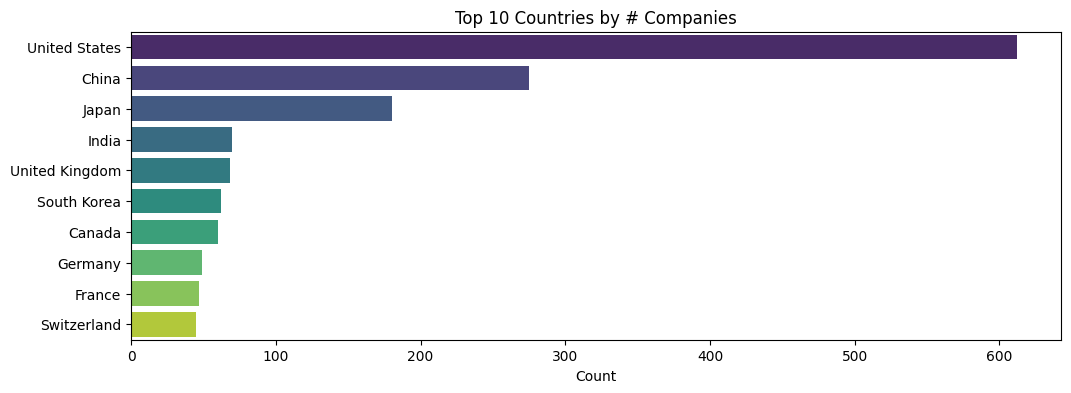

In [14]:
# 13. Geographic split — Top 10 countries by number of companies

# Extract the country name from the 'Headquarters' column
# Headquarters format: "City, Country"
# .str.split(', ') → splits into ["City", "Country"]
# .str[-1] → takes the last element (Country)
# .value_counts() → counts number of companies per country
# .head(10) → selects the top 10 countries
geo = (
    df['Headquarters']
    .str.split(', ').str[-1]
    .value_counts()
    .head(10)
)

# Create the plot
plt.figure(figsize=(12, 4))  # wide chart for readability

# Horizontal bar plot (Country on Y-axis, # Companies on X-axis)
sns.barplot(
    x=geo.values,   # counts of companies
    y=geo.index,    # country names
    palette='viridis'
)

# Title & labels
plt.title('Top 10 Countries by # Companies')
plt.xlabel('Count')
plt.ylabel('')

# Show the chart
plt.show()


# *Create a machine learning pipeline for clustering*

In [17]:
# Define features for clustering (use the numeric columns)
features = num_cols

pipe = make_pipeline(
    SimpleImputer(strategy='median'),  # Step 1: Fill missing values with column median
    StandardScaler(),                  # Step 2: Standardize features to mean=0, std=1
    KMeans(n_clusters=4, random_state=42)  # Step 3: Cluster into 4 groups
)

# Fit pipeline & predict cluster labels
# np.log1p() applies log(1 + x) to reduce skew in features (handles wide value ranges)
labels = pipe.fit_predict(np.log1p(df[features]))

# Save cluster labels back into the DataFrame
df['Cluster'] = labels

d:\Sharanya\.venv\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)
d:\Sharanya\.venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Sharanya\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\NEW\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\NEW\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_f

## KMeans clustering with log scaling
1.  Define the features for clustering
2.  Remove companies with negative or missing values in these features
3.  Scale the features using log scaling
4.  Standardize features (mean=0, std=1)
4.  Perform KMeans clustering on the scaled features
5.  Evaluate the quality of the clusters using the silhouette score

In [18]:
# Step 1: Define the features for clustering
features = ['Sales ($B)', 'Profit ($B)', 'Assets ($B)', 'Market Value ($B)']

# Step 2: Remove companies with negative or missing values in these features
# (Negative values can break log transform, NaNs break scaling/clustering)
df = df[(df[features] >= 0).all(axis=1)].dropna(subset=features)

# Step 3: Apply log transformation to reduce skew
# log1p = log(1 + x) prevents issues with zero values
Xlog = np.log1p(df[features])

# Step 4: Standardize features (mean=0, std=1) so all have equal influence in clustering
Xscl = StandardScaler().fit_transform(Xlog)

# Step 5: Apply KMeans clustering with 4 groups
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(Xscl)

# Step 6: View average financial metrics per cluster
print(df.groupby('Cluster')[features].mean())


         Sales ($B)  Profit ($B)  Assets ($B)  Market Value ($B)
Cluster                                                         
0         30.787306     2.470320    96.797860          42.531292
1         10.766276     0.828701    14.800209          18.692417
2        104.548909    18.525182   661.724682         225.782682
3          7.106448     0.653094    76.495099           6.106705


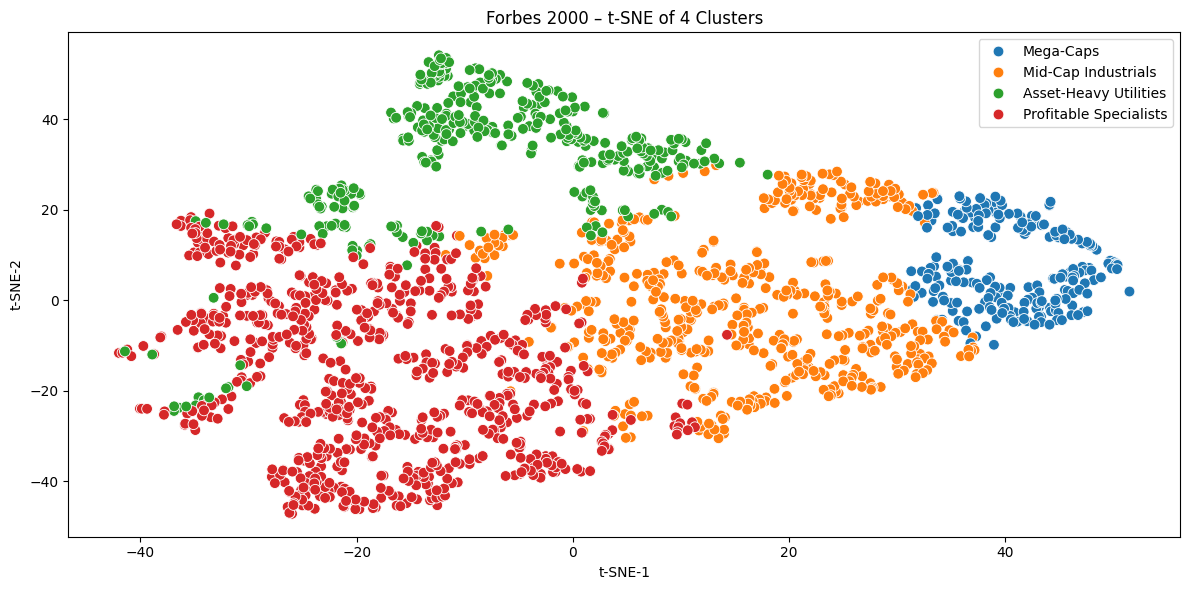

In [19]:
# Step 7-a: Run t-SNE to project 4-dimensional standardized data into 2D space
# This helps visualize clusters in a way humans can interpret
tsne = TSNE(n_components=2, random_state=42)
coords = tsne.fit_transform(Xscl)  # Xscl = standardized financial metrics

# Create a copy of the DataFrame and store t-SNE coordinates
df_vis = df.copy()
df_vis['t-SNE-1'] = coords[:, 0]
df_vis['t-SNE-2'] = coords[:, 1]

# Step 7-b: Map numeric cluster IDs to human-readable labels
# This improves interpretability for reports and dashboards
cluster_map = {
    0: 'Mid-Cap Industrials',       # Example: medium size, manufacturing-focused
    1: 'Profitable Specialists',    # Example: niche companies with high margins
    2: 'Mega-Caps',                  # Example: top financial powerhouses
    3: 'Asset-Heavy Utilities'      # Example: big infrastructure/energy players
}
df_vis['Cluster_Name'] = df_vis['Cluster'].map(cluster_map)

# Step 7-c: Plot the t-SNE projection with seaborn scatterplot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_vis,
    x='t-SNE-1', y='t-SNE-2',
    hue='Cluster_Name',       # Color by human-readable cluster names
    palette='tab10',          # 10-color palette
    s=60                      # Dot size
)
plt.title('Forbes 2000 – t-SNE of 4 Clusters')
plt.legend(title='')
plt.tight_layout()
plt.show()


In [24]:
# Create a filtered DataFrame where 'Profit ($B)' is negative
negative_profit = df[df['Profit ($B)'] < 0][['Company', 'Profit ($B)']]

# Print a clear heading for the risk report
print("\n--- NEGATIVE PROFIT COMPANIES ---")

# Display the list of companies and their losses
print(negative_profit)


--- NEGATIVE PROFIT COMPANIES ---
Empty DataFrame
Columns: [Company, Profit ($B)]
Index: []


In [25]:
#  Save cleaned data for further work
df.to_csv("forbes2005_clean.csv", index=False)
print("\nCleaned file saved → forbes2005_clean.csv")


Cleaned file saved → forbes2005_clean.csv
